# Using the QubitSubspaceManager to automate qubit reduction

`Symmer` currently implements the following qubit reduction techniques:
- Qubit Tapering
- Contextual subspace

We developed the `QubitSubspaceManager` to automate these subspace tools for ease-of-use, so that you can reduce the number of qubits in your problem *without* any prerequisite knowledge of how these techniques operate under the hood.

Let's import the Hamiltonian data for a single beryllium atom to demonstrate how to get started with the subspace manager:

In [1]:
import numpy as np
import os, json

cwd = os.getcwd()
notebook_dir =  os.path.dirname(cwd)
symmer_dir = os.path.dirname(notebook_dir)
test_dir = os.path.join(symmer_dir, 'tests')
ham_data_dir = os.path.join(test_dir, 'hamiltonian_data')
if not os.path.isdir(ham_data_dir):
    raise ValueError('cannot find data dir')
    
filename = 'Be_STO-3G_SINGLET_JW.json'

if filename not in os.listdir(ham_data_dir):
    raise ValueError('unknown file')
    
with open(os.path.join(ham_data_dir, filename), 'r') as infile:
    data_dict = json.load(infile)

Convert the Hamiltonian dictionary into a PauliwordOp object:

In [2]:
from symmer import PauliwordOp
from symmer.utils import exact_gs_energy

H = PauliwordOp.from_dictionary(data_dict['hamiltonian'])
print(f'Number of qubits in the Hamiltonian: {H.n_qubits}')
print(f'Number of terms  in the Hamiltonian: {H.n_terms}')

gs_energy, gs_state = exact_gs_energy(H.to_sparse_matrix)
print(f'Exact ground state energy: {gs_energy: .5f} Ha')

Number of qubits in the Hamiltonian: 10
Number of terms  in the Hamiltonian: 156
Exact ground state energy: -14.40366 Ha


Now import `QubitSubspaceManager` - you may supply the Hamiltonian as input and nothing else, although you will see better results if you are able to include additional information such as a reference state with non-zero overlap with the ground state (e.g. Hartree-Fock in the case of electronic structure).

In [3]:
from symmer import QubitSubspaceManager
from symmer.utils import exact_gs_energy

QSM = QubitSubspaceManager(H)

/home/tweaving/anaconda3/envs/symmer/lib/python3.8/site-packages/symmer/projection/qubit_subspace_manager.py:58: UserWarning: No reference state supplied - trying to identify one via alternative means.
  warnings.warn('No reference state supplied - trying to identify one via alternative means.')


As above, you run the qubit reduction procedure with no additional input, like so:

In [4]:
n_qubits = 4 # the desired number of qubits in the reduced space
H_reduced = QSM.get_reduced_hamiltonian(n_qubits=n_qubits)
reduced_gs_energy, reduced_gs_state = exact_gs_energy(H_reduced.to_sparse_matrix)

print(f'Number of qubits in the {n_qubits}-qubit reduced Hamiltonian: {H_reduced.n_qubits}')
print(f'Number of terms  in the {n_qubits}-qubit reduced Hamiltonian: {H_reduced.n_terms}')
print(f'Error with respect to the true ground state: {abs(gs_energy - reduced_gs_energy)*1e3: .3f} mHa')

/home/tweaving/anaconda3/envs/symmer/lib/python3.8/site-packages/symmer/operators/independent_op.py:248: UserWarning: The stabilizers ['IIIIX', 'IIIXI', 'IIXII'] were assigned zero values - bad reference state.
  warnings.warn(f'The stabilizers {S_zero} were assigned zero values - bad reference state.')


Number of qubits in the 4-qubit reduced Hamiltonian: 4
Number of terms  in the 4-qubit reduced Hamiltonian: 36
Error with respect to the true ground state:  0.304 mHa


Even with no additional input into the `QubitSubspaceManager`, we were able to identify a reduction from $10 \rightarrow 4$ qubits while only incurring an energy error of $0.3$mHa, well below the generally accepted threshold of chemical precision at $1.6$mHa! However, if we provide some additional information, we can do even better...

We shall also define the Hartree-Fock state and Coupled-Cluster operator:

In [5]:
from symmer import QuantumState

# Hartree-Fock state
HF_state = QuantumState(data_dict['data']['hf_array'])
# Coupled-Cluster Singles Doubles (CCSD) generator
CCSD_gen = PauliwordOp.from_dictionary(data_dict['data']['auxiliary_operators']['UCCSD_operator'])
print(f'Hartree-Fock state: {HF_state}\n')
print('Coupled-Cluster Singles Doubles (CCSD) generator:\n')
print(CCSD_gen)

Hartree-Fock state:  1.000+0.000j |1111000000>

Coupled-Cluster Singles Doubles (CCSD) generator:

 0.025+0.000j IIXXIIIIXY +
 0.025+0.000j IIXXIIIIYX +
-0.025+0.000j IIXYIIIIXX +
 0.025+0.000j IIXYIIIIYY +
-0.025+0.000j IIYXIIIIXX +
 0.025+0.000j IIYXIIIIYY +
-0.025+0.000j IIYYIIIIXY +
-0.025+0.000j IIYYIIIIYX +
 0.025+0.000j IIXXIIXYII +
 0.025+0.000j IIXXIIYXII +
-0.025+0.000j IIXYIIXXII +
 0.025+0.000j IIXYIIYYII +
-0.025+0.000j IIYXIIXXII +
 0.025+0.000j IIYXIIYYII +
-0.025+0.000j IIYYIIXYII +
-0.025+0.000j IIYYIIYXII +
 0.025+0.000j IIXXXYIIII +
 0.025+0.000j IIXXYXIIII +
-0.025+0.000j IIXYXXIIII +
 0.025+0.000j IIXYYYIIII +
-0.025+0.000j IIYXXXIIII +
 0.025+0.000j IIYXYYIIII +
-0.025+0.000j IIYYXYIIII +
-0.025+0.000j IIYYYXIIII +
-0.000+0.000j IXXIIIIIXY +
-0.000+0.000j IXXIIIIIYX +
 0.000+0.000j IXYIIIIIXX +
-0.000+0.000j IXYIIIIIYY +
 0.000+0.000j IYXIIIIIXX +
-0.000+0.000j IYXIIIIIYY +
 0.000+0.000j IYYIIIIIXY +
 0.000+0.000j IYYIIIIIYX +
-0.000+0.000j IXXIIIXYII +
-0.000+0.0

Now, we shall re-initialise the `QubitSubspaceManager` but with this new information:

In [6]:
from symmer import QubitSubspaceManager
from symmer.utils import exact_gs_energy

# input the Hartree-Fock state as the ref_state
QSM = QubitSubspaceManager(H, ref_state=HF_state)

n_qubits = 3 # the desired number of qubits in the reduced space
# include the CCSD generator as the aux_operator:
H_reduced = QSM.get_reduced_hamiltonian(n_qubits=n_qubits, aux_operator=CCSD_gen)
reduced_gs_energy, reduced_gs_state = exact_gs_energy(H_reduced.to_sparse_matrix)

print(f'Number of qubits in the {n_qubits}-qubit reduced Hamiltonian: {H_reduced.n_qubits}')
print(f'Number of terms  in the {n_qubits}-qubit reduced Hamiltonian: {H_reduced.n_terms}')
print(f'Error with respect to the true ground state: {abs(gs_energy - reduced_gs_energy)*1e3: .3f} mHa')

Number of qubits in the 3-qubit reduced Hamiltonian: 3
Number of terms  in the 3-qubit reduced Hamiltonian: 20
Error with respect to the true ground state:  0.327 mHa


We have now manged to maintain the same error level of $0.3$mHa but at an even more dramatic reduction of $10 \rightarrow 3$ qubits!

It is also possible the project the aux_operator into the same 3-qubit subspace so that you can then run VQE over the contextual subspace:

In [7]:
CCSD_reduced = QSM.project_auxiliary_operator(CCSD_gen)
HF_reduced   = QSM.project_auxiliary_state(HF_state)
print(f'{n_qubits}-qubit reduced Hartree-Fock state: {HF_reduced}\n')
print(f'{n_qubits}-qubit reduced CCSD generator:\n')
print(CCSD_reduced)

3-qubit reduced Hartree-Fock state:  1.000+0.000j |000>

3-qubit reduced CCSD generator:

-0.098+0.000j IIY +
-0.098+0.000j ZZY +
-0.098+0.000j IYI +
-0.098+0.000j ZYZ +
-0.098+0.000j YII +
-0.098+0.000j YZZ


And finally, VQE:

In [8]:
from symmer.evolution import VQE_Driver

vqe = VQE_Driver(observable=H_reduced, excitation_ops=CCSD_reduced, ref_state=HF_reduced)
vqe.verbose = False
vqe_result, interim_data = vqe.run()
vqe_error = vqe_result['fun'] - gs_energy
print(f'VQE error: {vqe_error: .5f} Ha')

VQE error:  0.00033 Ha


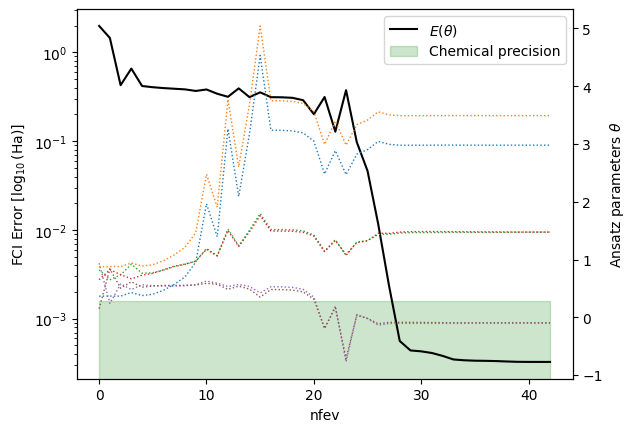

In [9]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
X,Y = zip(*interim_data['energy'].items())
axis.plot(X, abs(np.array(Y)-gs_energy), color='black', label='$E(\\theta)$')
axis.fill_between(X, 0, 0.0016, color='green', alpha=0.2, label='Chemical precision')
axis.set_yscale('log')
axis.set_ylabel('FCI Error [$\log_{10}$(Ha)]')
axis.set_xlabel('nfev')
axis_param = axis.twinx()
X,Y_params = zip(*interim_data['params'].items())
axis_param.plot(X, Y_params, ls=':', lw=1)
axis_param.set_ylabel('Ansatz parameters $\\theta$')
axis.legend()
plt.show()